In [42]:
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
#I want to plot output price vs release date
import matplotlib.pyplot as plt

#read in csv file and convert to pandas dataframe
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression, QuantileRegressor

In [43]:

df = pd.read_csv('art_analysis_inf_data.csv')
print(df.columns)
#convert price to float
df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])



# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)

#print the first 5 rows of the datafr

Index(['Model', 'Creator', 'License', 'Context\nWindow',
       'Artificial Analysis\nIntelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
       'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
       'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
       'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
       'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
       'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
       'Reasoning_TF', 'Further\nAnalysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Lowest Out

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_5098/2965051322.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


In [48]:
def plot_price_benchmark_regression(df, benchmark1_col, benchmark2_col, open_license_only=False, 
                                  min_benchmark1=None, max_benchmark1=None, 
                                  price_column='total price lowest gpqa', 
                                  exclude_dominated=False):
    """
    Plot log(Price) = alpha*time + beta*log(epoch_gpqa) + c regression
    
    Parameters:
    - df: DataFrame with the model data
    - benchmark1_col: Name of the first benchmark column to use (not used, kept for compatibility)
    - benchmark2_col: Name of the second benchmark column to use (not used, kept for compatibility)
    - open_license_only: If True, only include models with open licenses
    - min_benchmark1: Minimum score for first benchmark to include (optional, not used)
    - max_benchmark1: Maximum score for first benchmark to include (optional, not used)
    - price_column: Column name for price data (default: 'total price lowest')
    - exclude_dominated: If True, exclude models that are Pareto dominated by earlier models
    
    Returns fitted model coefficients and annual decrease rates
    """
    # Column names
    price_col = price_column
    license_col = 'License'
    epoch_col = benchmark1_col
    
    # Work on a copy
    df_work = df.copy()
    print(df_work.columns)
    # Convert epoch_gpqa to numeric
    df_work[epoch_col] = pd.to_numeric(df_work[epoch_col], errors='coerce')
    
    # Convert price to float
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

    
    # Optionally filter to open-license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]
    
    # Filter to rows with all necessary data
    required_cols = ['Release Date', price_col, epoch_col]
    df_sub = df_work.dropna(subset=required_cols)
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[epoch_col] > 0)]
    
    # Optionally filter out Pareto dominated models
    if exclude_dominated:
        df_sub = df_sub.sort_values('Release Date')
        non_dominated = []
        
        for i, row in df_sub.iterrows():
            # Check if this model is dominated by any previous model
            dominated = False
            for j in non_dominated:
                prev_row = df_sub.loc[j]
                # A model is dominated if there exists a previous model with:
                # 1. Better or equal epoch_gpqa AND
                # 2. Lower or equal price
                if (prev_row[epoch_col] >= row[epoch_col] and 
                    prev_row[price_col] <= row[price_col] and
                    (prev_row[epoch_col] > row[epoch_col] or 
                     prev_row[price_col] < row[price_col])):
                    dominated = True
                    break
            
            if not dominated:
                non_dominated.append(i)
                
                # Also remove any previously added models that this one dominates
                new_non_dominated = []
                for j in non_dominated[:-1]:  # All except the one we just added
                    prev_row = df_sub.loc[j]
                    if not (row[epoch_col] >= prev_row[epoch_col] and 
                           row[price_col] <= prev_row[price_col] and
                           (row[epoch_col] > prev_row[epoch_col] or 
                            row[price_col] < prev_row[price_col])):
                        new_non_dominated.append(j)
                
                non_dominated = new_non_dominated + [i]
        
        df_sub = df_sub.loc[non_dominated]
    
    if len(df_sub) < 3:  # Need at least 3 points for 2 predictors + intercept
        print(f"Warning: Only {len(df_sub)} data points available. Need at least 3 for regression with time and epoch_gpqa.")
        return None, None, None
    
    # Prepare variables for regression
    df_sub = df_sub.sort_values('Release Date').copy()
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
    
    # Features: time, log(epoch_gpqa)
    X = np.column_stack([
        df_sub['Date_Ordinal'].values,
        np.log(df_sub[epoch_col].values)
    ])
    
    # Target: log(total price lowest)
    y = np.log(df_sub[price_col].values)
    
    # Fit linear regression
    model = LinearRegression().fit(X, y)
    alpha, beta = model.coef_
    c = model.intercept_
    r2 = model.score(X, y)
    
    # Calculate adjusted R²
    n = len(df_sub)
    p = 2  # number of predictors
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # Calculate annual decrease rates
    annual_log_change = alpha * 365
    annual_pct_change = (np.exp(annual_log_change) - 1) * 100
    factor_change_per_year = np.exp(annual_log_change)
    
    # Express as factor decrease if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_per_year = 1 / factor_change_per_year
    else:
        factor_decrease_per_year = None
    
    # Calculate confidence intervals for the time coefficient
    y_pred = model.predict(X)
    residuals = y - y_pred
    mse = np.sum(residuals**2) / (n - p - 1)
    
    # Calculate variance-covariance matrix
    X_mean_centered = X - np.mean(X, axis=0)
    cov_matrix = np.linalg.inv(X_mean_centered.T.dot(X_mean_centered)) * mse
    
    # Standard error for alpha (time coefficient)
    se_alpha = np.sqrt(cov_matrix[0, 0])
    se_annual = se_alpha * 365
    
    # t-statistic for 90% confidence interval
    from scipy import stats
    t_stat = stats.t.ppf(0.95, n - p - 1)
    
    # Confidence interval for annual log change
    annual_log_change_lower = annual_log_change - t_stat * se_annual
    annual_log_change_upper = annual_log_change + t_stat * se_annual
    
    # Convert to factor change confidence interval
    factor_change_lower = np.exp(annual_log_change_lower)
    factor_change_upper = np.exp(annual_log_change_upper)
    
    # Express as factor decrease for confidence interval if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_lower = 1 / factor_change_upper
        factor_decrease_upper = 1 / factor_change_lower
    else:
        factor_decrease_lower = None
        factor_decrease_upper = None
    
    # Generate predictions for plotting
    min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range = np.linspace(min_ord, max_ord, 100)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]
    
    # For visualization, show trend at median values
    median_epoch = df_sub[epoch_col].median()
    
    X_pred = np.column_stack([
        x_range,
        np.full(len(x_range), np.log(median_epoch))
    ])
    y_pred = model.predict(X_pred)
    
    # Plot results
    plt.figure(figsize=(14, 8))
    
    # Color points by epoch_gpqa
    scatter = plt.scatter(
        df_sub['Release Date'], 
        df_sub[price_col],
        c=df_sub[epoch_col], 
        cmap='viridis', 
        alpha=0.7,
        s=60,
        label='Data points'
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label(f'{epoch_col}')
    
    # Plot regression line (at median values)
    if factor_decrease_per_year:
        regression_label = (f'Regression (at median {epoch_col}={median_epoch:.1f})\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor decrease: {factor_decrease_per_year:.3f}×/yr (90% CI: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}])\n'
                           f'R² = {r2:.3f}, Adj. R² = {adjusted_r2:.3f}')
    else:
        regression_label = (f'Regression (at median {epoch_col}={median_epoch:.1f})\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor change: {factor_change_per_year:.3f}×/yr (90% CI: [{factor_change_lower:.3f}, {factor_change_upper:.3f}])\n'
                           f'R² = {r2:.3f}, Adj. R² = {adjusted_r2:.3f}')
    
    plt.plot(x_dates, np.exp(y_pred), 'r-', lw=3, label=regression_label)
    
    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Total Price Lowest (USD per 1M tokens)')
    
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    pareto_label = "non-dominated models only" if exclude_dominated else "all models"
    
    plt.title(f'Price vs Time & log(epoch_gpqa) Regression ({lic_label}, {pareto_label})\n'
              f'log(Price) = {alpha:.6f}×time + {beta:.3f}×log(epoch_gpqa) + {c:.3f}')
    
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\nRegression Results:")
    print(f"Model: log(Price) = {alpha:.6f}×time + {beta:.3f}×log(epoch_gpqa) + {c:.3f}")
    print(f"R² score: {r2:.4f}")
    print(f"Adjusted R² score: {adjusted_r2:.4f}")
    print(f"\nTime coefficient (alpha): {alpha:.6f}")
    print(f"Annual percentage change: {annual_pct_change:.2f}%/yr")
    
    if factor_decrease_per_year:
        print(f"Annual factor decrease: {factor_decrease_per_year:.3f}×/yr")
        print(f"90% CI for factor decrease: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}]")
    else:
        print(f"Annual factor change: {factor_change_per_year:.3f}×/yr")
        print(f"90% CI for factor change: [{factor_change_lower:.3f}, {factor_change_upper:.3f}]")
    
    print(f"log(epoch_gpqa) coefficient (beta): {beta:.3f}")
    print(f"Intercept (c): {c:.3f}")
    print(f"\nData points used: {len(df_sub)}")
    
    return model, df_sub, {
        'alpha': alpha,
        'beta': beta,
        'c': c,
        'annual_pct_change': annual_pct_change,
        'factor_change_per_year': factor_change_per_year,
        'factor_decrease_per_year': factor_decrease_per_year if factor_change_per_year < 1 else None,
        'factor_change_ci_lower': factor_change_lower,
        'factor_change_ci_upper': factor_change_upper,
        'factor_decrease_ci_lower': factor_decrease_lower if factor_change_per_year < 1 else None,
        'factor_decrease_ci_upper': factor_decrease_upper if factor_change_per_year < 1 else None,
        'r2_score': r2,
        'adjusted_r2_score': adjusted_r2
    }

# Example usage:
model, data, results = plot_price_benchmark_regression(
    df, 
    benchmark1_col="epoch_gpqa", 
    benchmark2_col=None,
    min_benchmark1=0,
    max_benchmark1=90,
    open_license_only=False, 
    price_column="total price lowest gpqa", 
    exclude_dominated=False
)

Index(['Model', 'Creator', 'License', 'Context\nWindow',
       'Artificial Analysis\nIntelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
       'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
       'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
       'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
       'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
       'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
       'Reasoning_TF', 'Further\nAnalysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Lowest Out

Available columns: ['Model', 'Creator', 'License', 'Context\nWindow', 'Artificial Analysis\nIntelligence Index', 'MMLU-Pro (Reasoning & Knowledge)', 'GPQA Diamond (Scientific Reasoning)', "Humanity's Last Exam (Reasoning & Knowledge)", 'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)', 'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)', 'Multilingual Index (Artificial Analysis)', 'Chatbot Arena', 'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens', 'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s', 'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s', 'Median\nFirst Chunk (s)', 'First Answer\nToken (s)', 'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)', 'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)', 'Reasoning_TF', 'Further\nAnalysis', 'Release Date', 'Parameters', 'Known Active Parameters', 'Lowest Output Price Found AA', 'Lowest Input Price AA', 'Lowest Blended Price AA', 'Latency', 'token/s

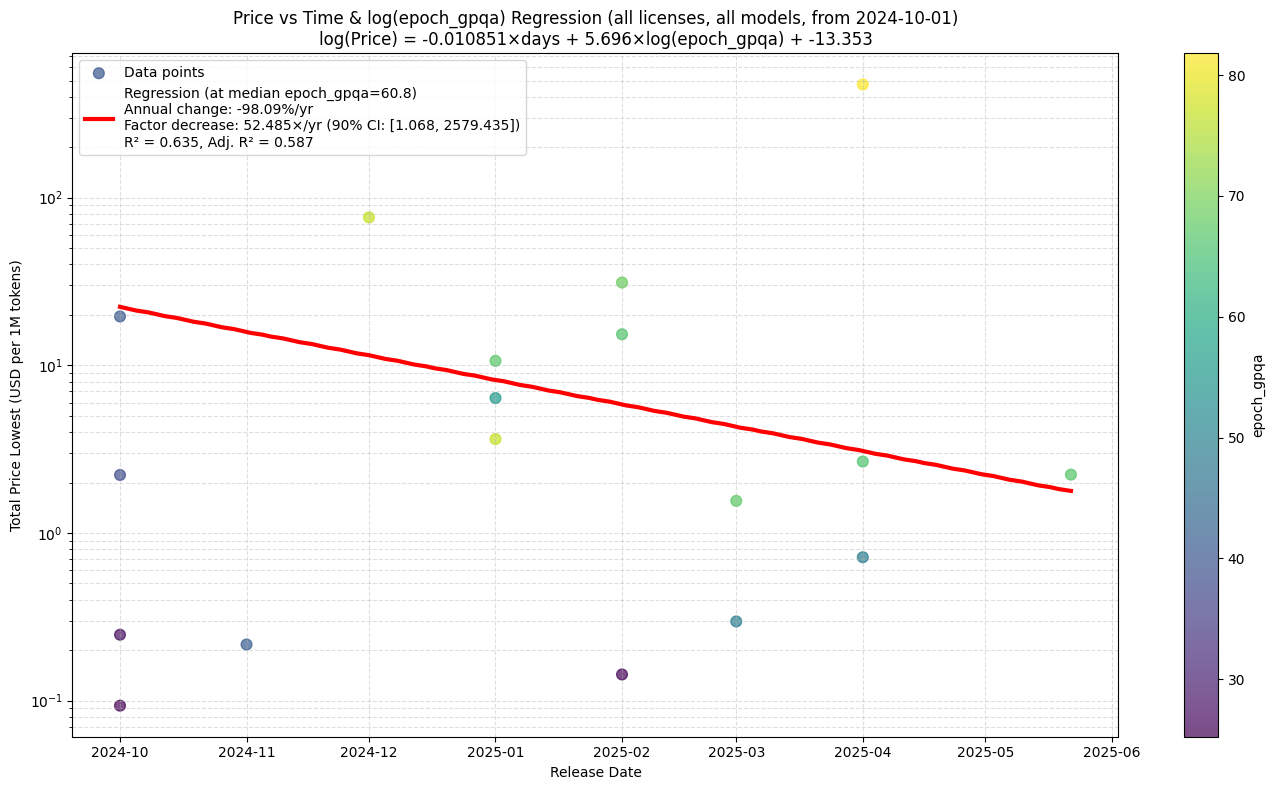


Regression Results:
Model: log(Price) = -0.010851×days + 5.696×log(epoch_gpqa) + -13.353
R² score: 0.6353
Adjusted R² score: 0.5867

Time coefficient (alpha): -0.010851 per day
This represents a daily log change of -0.010851
Annual percentage change: -98.09%/yr
Annual factor decrease: 52.485×/yr
90% CI for factor decrease: [1.068, 2579.435]
log(epoch_gpqa) coefficient (beta): 5.696
Intercept (c): -13.353

Data points used: 18


In [57]:
def plot_price_benchmark_regression(df, benchmark1_col, benchmark2_col, open_license_only=False, 
                                  min_benchmark1=None, max_benchmark1=None, 
                                  price_column='total price lowest gpqa', 
                                  exclude_dominated=False, min_date=None):
    """
    Plot log(Price) = alpha*time + beta*log(benchmark) + c regression
    
    Parameters:
    - df: DataFrame with the model data
    - benchmark1_col: Name of the first benchmark column to use for regression
    - benchmark2_col: Name of the second benchmark column to use (not used, kept for compatibility)
    - open_license_only: If True, only include models with open licenses
    - min_benchmark1: Minimum score for first benchmark to include (optional)
    - max_benchmark1: Maximum score for first benchmark to include (optional)
    - price_column: Column name for price data (default: 'total price lowest gpqa')
    - exclude_dominated: If True, exclude models that are Pareto dominated by earlier models
    - min_date: Only include models released on or after this date. Can be:
                - datetime object
                - string in 'YYYY-MM-DD' format (e.g., '2024-01-01')
                - string in readable format (e.g., 'January 1, 2024')
                If None, includes all dates
    
    Returns fitted model coefficients and annual decrease rates
    
    Note: The time variable in the regression is measured in DAYS since baseline (2023-01-01).
          Alpha coefficient represents the daily log change in price.
          Annual changes are calculated by multiplying alpha by 365.
    """
    # Column names
    price_col = price_column
    license_col = 'License'
    benchmark_col = benchmark1_col  # Use the provided benchmark column
    date_col = 'Release Date'
    
    # Work on a copy
    df_work = df.copy()
    print("Available columns:", df_work.columns.tolist())
    
    # Check if required columns exist
    required_cols = [date_col, price_col, benchmark_col]
    missing_cols = [col for col in required_cols if col not in df_work.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        return None, None, None
    
    # Debug: Check data in benchmark column
    print(f"\nDebugging {benchmark_col} column:")
    print(f"Column type: {df_work[benchmark_col].dtype}")
    print(f"Sample values: {df_work[benchmark_col].head(10).tolist()}")
    print(f"Non-null count: {df_work[benchmark_col].notna().sum()}")
    print(f"Unique values (first 10): {df_work[benchmark_col].dropna().unique()[:10]}")
    
    # Clean and convert benchmark to numeric
    # Handle percentage strings if they exist
    if df_work[benchmark_col].dtype == 'object':
        # Remove percentage signs and convert to numeric
        df_work[benchmark_col] = df_work[benchmark_col].astype(str).str.replace('%', '').str.replace(' ', '')
        # Replace empty strings and 'nan' with NaN
        df_work[benchmark_col] = df_work[benchmark_col].replace(['', 'nan', 'None'], np.nan)
    
    df_work[benchmark_col] = pd.to_numeric(df_work[benchmark_col], errors='coerce')
    
    # Clean and convert price to numeric
    if df_work[price_col].dtype == 'object':
        # Remove dollar signs, spaces, and convert to numeric
        df_work[price_col] = df_work[price_col].astype(str).str.replace('$', '').str.replace(' ', '').str.replace(',', '')
        df_work[price_col] = df_work[price_col].replace(['', 'nan', 'None'], np.nan)
    
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    
    # Convert Release Date to datetime if it's not already
    if df_work[date_col].dtype == 'object':
        df_work[date_col] = pd.to_datetime(df_work[date_col], format='%Y-%m-%d', errors='coerce')
    
    # Apply time filter if specified
    if min_date is not None:
        # Convert min_date to datetime if it's a string
        if isinstance(min_date, str):
            try:
                # Try standard format first (YYYY-MM-DD)
                min_date_dt = pd.to_datetime(min_date, format='%Y-%m-%d')
            except:
                try:
                    # Try flexible parsing for readable formats
                    min_date_dt = pd.to_datetime(min_date)
                except:
                    print(f"Warning: Could not parse min_date '{min_date}'. Expected format: 'YYYY-MM-DD' or readable date")
                    min_date_dt = None
        else:
            min_date_dt = min_date
        
        if min_date_dt is not None:
            initial_count = len(df_work)
            df_work = df_work[df_work[date_col] >= min_date_dt]
            print(f"Applied time filter (>= {min_date_dt.strftime('%Y-%m-%d')}): {initial_count} -> {len(df_work)} rows")
    
    # Debug: Check data after conversion
    print(f"\nAfter conversion:")
    print(f"Valid {benchmark_col} values: {df_work[benchmark_col].notna().sum()}")
    print(f"Valid {price_col} values: {df_work[price_col].notna().sum()}")
    print(f"Valid Release Date values: {df_work[date_col].notna().sum()}")
    print(f"Values > 0 in {benchmark_col}: {(df_work[benchmark_col] > 0).sum()}")
    print(f"Values > 0 in {price_col}: {(df_work[price_col] > 0).sum()}")
    
    # Optionally filter to open-license only
    if open_license_only:
        if license_col in df_work.columns:
            df_work = df_work[
                df_work[license_col].notna() &
                df_work[license_col].str.contains('open', case=False, na=False)
            ]
        else:
            print(f"Warning: {license_col} column not found, skipping license filter")
    
    # Apply benchmark range filters if specified
    if min_benchmark1 is not None:
        df_work = df_work[df_work[benchmark_col] >= min_benchmark1]
        print(f"After filtering for {benchmark_col} >= {min_benchmark1}: {len(df_work)} rows")
    
    if max_benchmark1 is not None:
        df_work = df_work[df_work[benchmark_col] <= max_benchmark1]
        print(f"After filtering for {benchmark_col} <= {max_benchmark1}: {len(df_work)} rows")
    
    # Filter to rows with all necessary data
    df_sub = df_work.dropna(subset=required_cols)
    print(f"After dropping NaN values: {len(df_sub)} rows")
    
    # Filter for positive values
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[benchmark_col] > 0)]
    print(f"After filtering for positive values: {len(df_sub)} rows")
    
    # Additional debugging: show what data we have
    if len(df_sub) > 0:
        print(f"\nSample of filtered data:")
        print(df_sub[['Model', date_col, price_col, benchmark_col]].head())
    else:
        print(f"\nNo valid data found. Checking individual conditions:")
        print(f"Rows with valid Release Date: {df_work[date_col].notna().sum()}")
        print(f"Rows with valid {price_col}: {df_work[price_col].notna().sum()}")
        print(f"Rows with valid {benchmark_col}: {df_work[benchmark_col].notna().sum()}")
        print(f"Rows with {price_col} > 0: {(df_work[price_col] > 0).sum()}")
        print(f"Rows with {benchmark_col} > 0: {(df_work[benchmark_col] > 0).sum()}")
        
        # Show some sample data for debugging
        sample_data = df_work[['Model', date_col, price_col, benchmark_col]].head(10)
        print(f"\nSample data for debugging:")
        print(sample_data)
    
    # Optionally filter out Pareto dominated models
    if exclude_dominated and len(df_sub) > 0:
        df_sub = df_sub.sort_values(date_col)
        non_dominated = []
        
        for i, row in df_sub.iterrows():
            # Check if this model is dominated by any previous model
            dominated = False
            for j in non_dominated:
                prev_row = df_sub.loc[j]
                # A model is dominated if there exists a previous model with:
                # 1. Better or equal benchmark score AND
                # 2. Lower or equal price
                if (prev_row[benchmark_col] >= row[benchmark_col] and 
                    prev_row[price_col] <= row[price_col] and
                    (prev_row[benchmark_col] > row[benchmark_col] or 
                     prev_row[price_col] < row[price_col])):
                    dominated = True
                    break
            
            if not dominated:
                non_dominated.append(i)
                
                # Also remove any previously added models that this one dominates
                new_non_dominated = []
                for j in non_dominated[:-1]:  # All except the one we just added
                    prev_row = df_sub.loc[j]
                    if not (row[benchmark_col] >= prev_row[benchmark_col] and 
                           row[price_col] <= prev_row[price_col] and
                           (row[benchmark_col] > prev_row[benchmark_col] or 
                            row[price_col] < prev_row[price_col])):
                        new_non_dominated.append(j)
                
                non_dominated = new_non_dominated + [i]
        
        df_sub = df_sub.loc[non_dominated]
        print(f"After Pareto filtering: {len(df_sub)} rows")
    
    if len(df_sub) < 3:  # Need at least 3 points for 2 predictors + intercept
        print(f"Warning: Only {len(df_sub)} data points available. Need at least 3 for regression with time and {benchmark_col}.")
        return None, None, None
    
    # Prepare variables for regression
    df_sub = df_sub.sort_values(date_col).copy()
    
    # Use a meaningful baseline date instead of ordinal
    baseline_date = datetime(2023, 1, 1)  # baseline date for time calculation
    df_sub['Days_Since_Baseline'] = (df_sub[date_col] - baseline_date).dt.days
    
    print(f"\nTime variable details:")
    print(f"Baseline date: {baseline_date.strftime('%Y-%m-%d')}")
    print(f"Time range in dataset: {df_sub['Days_Since_Baseline'].min():.0f} to {df_sub['Days_Since_Baseline'].max():.0f} days")
    print(f"Time range in years: {df_sub['Days_Since_Baseline'].min()/365:.2f} to {df_sub['Days_Since_Baseline'].max()/365:.2f} years")
    
    # Features: time (as days since baseline), log(benchmark)
    X = np.column_stack([
        df_sub['Days_Since_Baseline'].values,  # Time in DAYS since baseline
        np.log(df_sub[benchmark_col].values)
    ])
    
    # Target: log(total price)
    y = np.log(df_sub[price_col].values)
    
    # Fit linear regression
    model = LinearRegression().fit(X, y)
    alpha, beta = model.coef_
    c = model.intercept_
    r2 = model.score(X, y)
    
    # Calculate adjusted R²
    n = len(df_sub)
    p = 2  # number of predictors
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # Calculate annual decrease rates
    # alpha is the daily log change, so multiply by 365 to get annual log change
    annual_log_change = alpha * 365
    annual_pct_change = (np.exp(annual_log_change) - 1) * 100
    factor_change_per_year = np.exp(annual_log_change)
    
    # Express as factor decrease if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_per_year = 1 / factor_change_per_year
    else:
        factor_decrease_per_year = None
    
    # Calculate confidence intervals for the time coefficient
    y_pred = model.predict(X)
    residuals = y - y_pred
    mse = np.sum(residuals**2) / (n - p - 1)
    
    # Calculate variance-covariance matrix
    X_mean_centered = X - np.mean(X, axis=0)
    cov_matrix = np.linalg.inv(X_mean_centered.T.dot(X_mean_centered)) * mse
    
    # Standard error for alpha (time coefficient)
    se_alpha = np.sqrt(cov_matrix[0, 0])
    se_annual = se_alpha * 365  # Convert daily SE to annual SE
    
    # t-statistic for 90% confidence interval
    from scipy import stats
    t_stat = stats.t.ppf(0.95, n - p - 1)
    
    # Confidence interval for annual log change
    annual_log_change_lower = annual_log_change - t_stat * se_annual
    annual_log_change_upper = annual_log_change + t_stat * se_annual
    
    # Convert to factor change confidence interval
    factor_change_lower = np.exp(annual_log_change_lower)
    factor_change_upper = np.exp(annual_log_change_upper)
    
    # Express as factor decrease for confidence interval if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_lower = 1 / factor_change_upper
        factor_decrease_upper = 1 / factor_change_lower
    else:
        factor_decrease_lower = None
        factor_decrease_upper = None
    
    # Generate predictions for plotting
    min_days, max_days = df_sub['Days_Since_Baseline'].min(), df_sub['Days_Since_Baseline'].max()
    x_range = np.linspace(min_days, max_days, 100)
    x_dates = [baseline_date + pd.Timedelta(days=int(d)) for d in x_range]
    
    # For visualization, show trend at median values
    median_benchmark = df_sub[benchmark_col].median()
    
    X_pred = np.column_stack([
        x_range,
        np.full(len(x_range), np.log(median_benchmark))
    ])
    y_pred = model.predict(X_pred)
    
    # Plot results
    plt.figure(figsize=(14, 8))
    
    # Color points by benchmark score
    scatter = plt.scatter(
        df_sub[date_col], 
        df_sub[price_col],
        c=df_sub[benchmark_col], 
        cmap='viridis', 
        alpha=0.7,
        s=60,
        label='Data points'
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label(f'{benchmark_col}')
    
    # Plot regression line (at median values)
    if factor_decrease_per_year:
        regression_label = (f'Regression (at median {benchmark_col}={median_benchmark:.1f})\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor decrease: {factor_decrease_per_year:.3f}×/yr (90% CI: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}])\n'
                           f'R² = {r2:.3f}, Adj. R² = {adjusted_r2:.3f}')
    else:
        regression_label = (f'Regression (at median {benchmark_col}={median_benchmark:.1f})\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor change: {factor_change_per_year:.3f}×/yr (90% CI: [{factor_change_lower:.3f}, {factor_change_upper:.3f}])\n'
                           f'R² = {r2:.3f}, Adj. R² = {adjusted_r2:.3f}')
    
    plt.plot(x_dates, np.exp(y_pred), 'r-', lw=3, label=regression_label)
    
    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Total Price Lowest (USD per 1M tokens)')
    
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    pareto_label = "non-dominated models only" if exclude_dominated else "all models"
    time_label = f", from {min_date}" if min_date is not None else ""
    
    plt.title(f'Price vs Time & log({benchmark_col}) Regression ({lic_label}, {pareto_label}{time_label})\n'
              f'log(Price) = {alpha:.6f}×days + {beta:.3f}×log({benchmark_col}) + {c:.3f}')
    
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\nRegression Results:")
    print(f"Model: log(Price) = {alpha:.6f}×days + {beta:.3f}×log({benchmark_col}) + {c:.3f}")
    print(f"R² score: {r2:.4f}")
    print(f"Adjusted R² score: {adjusted_r2:.4f}")
    print(f"\nTime coefficient (alpha): {alpha:.6f} per day")
    print(f"This represents a daily log change of {alpha:.6f}")
    print(f"Annual percentage change: {annual_pct_change:.2f}%/yr")
    
    if factor_decrease_per_year:
        print(f"Annual factor decrease: {factor_decrease_per_year:.3f}×/yr")
        print(f"90% CI for factor decrease: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}]")
    else:
        print(f"Annual factor change: {factor_change_per_year:.3f}×/yr")
        print(f"90% CI for factor change: [{factor_change_lower:.3f}, {factor_change_upper:.3f}]")
    
    print(f"log({benchmark_col}) coefficient (beta): {beta:.3f}")
    print(f"Intercept (c): {c:.3f}")
    print(f"\nData points used: {len(df_sub)}")
    
    return model, df_sub, {
        'alpha': alpha,
        'beta': beta,
        'c': c,
        'annual_pct_change': annual_pct_change,
        'factor_change_per_year': factor_change_per_year,
        'factor_decrease_per_year': factor_decrease_per_year if factor_change_per_year < 1 else None,
        'factor_change_ci_lower': factor_change_lower,
        'factor_change_ci_upper': factor_change_upper,
        'factor_decrease_ci_lower': factor_decrease_lower if factor_change_per_year < 1 else None,
        'factor_decrease_ci_upper': factor_decrease_upper if factor_change_per_year < 1 else None,
        'r2_score': r2,
        'adjusted_r2_score': adjusted_r2
    }

# Example usage:
model, data, results = plot_price_benchmark_regression(
    df, 
    benchmark1_col="epoch_gpqa", 
    benchmark2_col=None,
    min_benchmark1=0,
    max_benchmark1=100,
    open_license_only=False, 
    price_column="total price lowest gpqa", 
    exclude_dominated=False,
    min_date='2024-10-01'  # Only include models from 2024 onwards
)


# Bin Method

MMLU 30-50% R² = 0.617
MMLU 50-70% R² = 0.478
MMLU 70-90% R² = 1.000


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_5098/682396447.py:196: RuntimeWarning: overflow encountered in power
  10**y_upper,
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_5098/682396447.py:196: RuntimeWarning: overflow encountered in power
  10**y_upper,


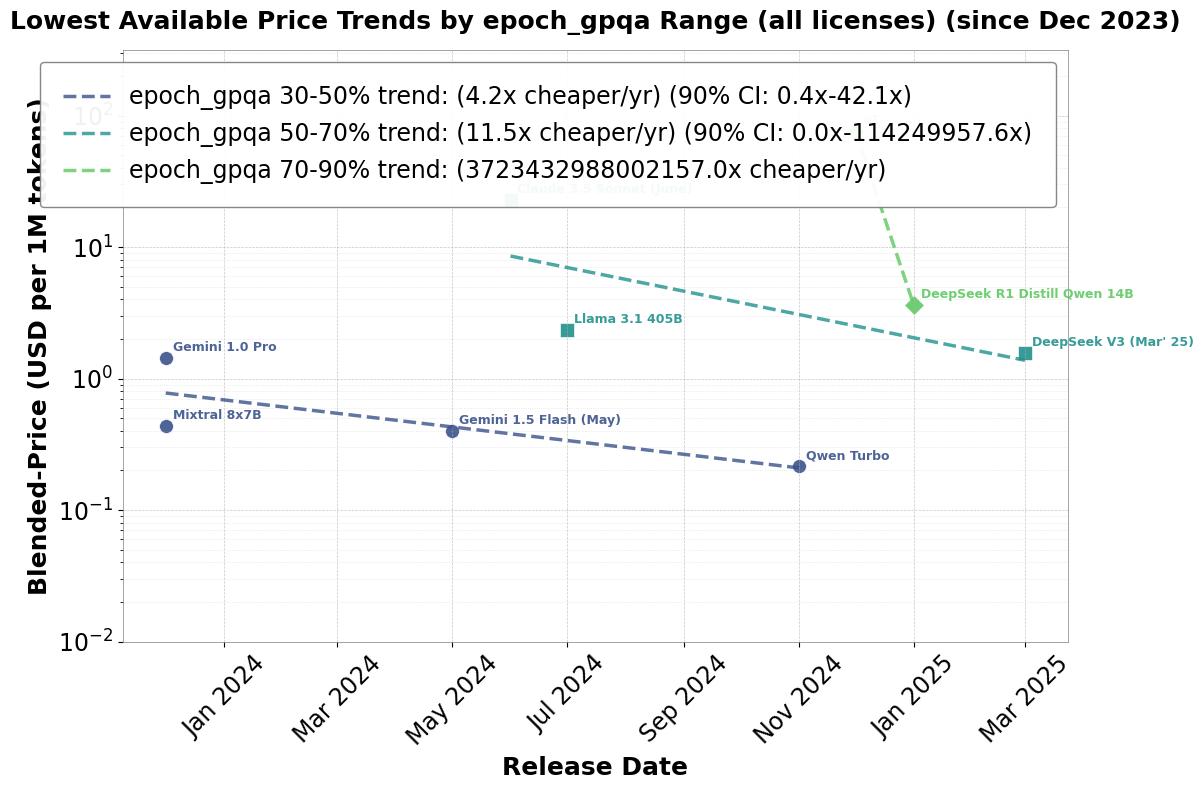

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import scienceplots
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats


# get predictions at highly skewed
#R^2 regression


def plot_combined_record_small_trends(open_license_only=False, price_col='Lowest Blended Price AA', show_model_names=False, min_date=datetime(2023, 1, 1), confidence_interval=True, include_chinese=None, benchmark_col='MMLU-Pro (Reasoning & Knowledge)', mmlu_ranges=[(30, 50), (50, 70), (70, 90)]):
    """
    Plot record-small points and their trend lines for specified MMLU ranges 
    on a single graph with enhanced styling. Includes 90% confidence intervals.
    
    Parameters:
      open_license_only: If True, only include models with open licenses
      price_col: Column name for price data (default: 'Lowest Blended Price AA')
      show_model_names: If True, displays model names next to record-small points
      min_date: If provided, only include models released on or after this date (datetime or string)
                Default is January 1, 2024
      confidence_interval: If True, displays 90% confidence intervals for trend lines
      include_chinese: Filter for Chinese models - if True, only include Chinese models; 
                      if False, exclude Chinese models; if None, include all models
      benchmark_col: Column name for the benchmark to use (default: 'MMLU-Pro (Reasoning & Knowledge)')
      mmlu_ranges: List of tuples defining MMLU score ranges (default: [(30, 50), (50, 70), (70, 90)])
    """
    # Set up the styling with standard matplotlib font
    plt.rcParams['font.family'] = 'sans-serif'
    
    # Create figure with specific dimensions
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    
    # Set background to white
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Use provided MMLU ranges with custom palette
    palette = sns.color_palette("viridis", n_colors=len(mmlu_ranges))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # Extended list of markers
    
    # --- column names ---
    mmlu_col = benchmark_col
    license_col = 'License'
    chinese_col = 'Chinese'
    
    # Store all data for setting axis limits
    all_dates = []
    all_prices = []
    
    for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
        color = palette[i]
        marker = markers[i % len(markers)]  # Cycle through markers if we have more ranges than markers
        
        # 1) Work on a copy
        df_work = df.copy()

        # 2) Convert MMLU "XX%" → float
        df_work[mmlu_col] = (
            df_work[mmlu_col].astype(str)
                             .str.replace('%','',regex=False)
                             .astype(float)
        )

        # 3) Convert price "$X,XXX" → float
        df_work[price_col] = (
            df_work[price_col].astype(str)
                             .str.replace('[$,]','',regex=True)
        )
        df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

        # 4) Optionally filter to open‐license only
        if open_license_only:
            df_work = df_work[
                df_work[license_col].notna() &
                df_work[license_col].str.contains('open', case=False, na=False)
            ]
            
        # 4b) Filter by date if min_date is provided
        if min_date is not None:
            if isinstance(min_date, str):
                min_date = pd.to_datetime(min_date)
            df_work = df_work[df_work['Release Date'] >= min_date]
            
        # 4c) Filter by Chinese models if specified
        if include_chinese is not None:
            if include_chinese:
                # Only include Chinese models (where Chinese column is TRUE)
                df_work = df_work[df_work[chinese_col] == True]
            else:
                # Exclude Chinese models (where Chinese column is TRUE)
                df_work = df_work[(df_work[chinese_col] != True) | (df_work[chinese_col].isna())]

        # 5) Filter to MMLU range
        df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

        # 6) Drop missing Release Date or price, remove non‐positive prices
        df_sub = df_sub.dropna(subset=['Release Date', price_col])
        df_sub = df_sub[df_sub[price_col] > 0]

        # Skip if no data
        if len(df_sub) == 0:
            continue

        # 7) Sort & compute ordinal date
        df_sub = df_sub.sort_values('Release Date')
        df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

        # 8) "Record‐small" = running minima of price
        df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
        record_small = df_sub[df_sub['Is_Record_Small']].copy()
        
        # Skip if no record small points
        if len(record_small) == 0:
            continue

        # 9) Linear regression on record small points (log scale)
        X_rec = record_small['Date_Ordinal'].values.reshape(-1,1)
        y_rec_log = np.log10(record_small[price_col].values)
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        
        # Calculate R^2 value
        r_squared = rec_ols.score(X_rec, y_rec_log)
        print(f"MMLU {min_mmlu}-{max_mmlu}% R² = {r_squared:.3f}")
        
        # 10) Create prediction line
        min_ord, max_ord = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
        x_range = np.arange(min_ord, max_ord + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
        
        # 11) Calculate annual decrease rate
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365
        
        # Calculate 90% confidence intervals for the slope if requested
        ci_label = ""
        n = len(X_rec)
        if confidence_interval and n > 2:  # Need at least 3 points for confidence interval
            # Calculate residuals and standard error
            y_pred = rec_ols.predict(X_rec)
            residuals = y_rec_log - y_pred
            mse = np.sum(residuals**2) / (n - 2)
            se = np.sqrt(mse / np.sum((X_rec - np.mean(X_rec))**2))
            
            # t-value for 90% confidence interval (two-tailed)
            t_val = stats.t.ppf(0.95, n - 2)
            
            # Confidence interval for slope
            ci_lower = rec_ols.coef_[0] - t_val * se
            ci_upper = rec_ols.coef_[0] + t_val * se
            
            # Convert to annual factors
            annual_factor_lower = 1 / (10**ci_upper)**365  # Note: Upper CI of negative slope gives lower factor
            annual_factor_upper = 1 / (10**ci_lower)**365  # Note: Lower CI of negative slope gives upper factor
            
            ci_label = f" (90% CI: {annual_factor_lower:.1f}x-{annual_factor_upper:.1f}x)"

        # 12) Plot record small points with enhanced styling
        sns.scatterplot(
            x=record_small['Release Date'], 
            y=record_small[price_col],
            color=color, 
            s=100,  # Slightly larger points
            marker=marker, 
            alpha=0.9,
            edgecolor='white',
            linewidth=0.5,
            ax=ax
        )
        
        # 13) Plot trend line with enhanced styling
        ax.plot(
            x_dates, 
            10**y_rec_log_pred, 
            color=color, 
            linestyle='--', 
            linewidth=2.5,
            alpha=0.8,
            label=f'{benchmark_col.split(" ")[0]} {min_mmlu}-{max_mmlu}% trend: ({annual_factor_rec:.1f}x cheaper/yr){ci_label}'
        )
        
        # Plot confidence intervals if we have enough data points and confidence_interval is True
        if confidence_interval and n > 2:
            y_lower = ci_lower * x_range + rec_ols.intercept_
            y_upper = ci_upper * x_range + rec_ols.intercept_
            
            ax.fill_between(
                x_dates,
                10**y_lower,
                10**y_upper,
                color=color,
                alpha=0.1
            )
        
        # 14) Add model names if requested
        if show_model_names:
            for idx, row in record_small.iterrows():
                ax.annotate(
                    row['Model'], 
                    (row['Release Date'], row[price_col]),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9,
                    color=color,
                    fontweight='bold',
                    alpha=0.9
                )
        
        # Store data for axis limits
        all_dates.extend(record_small['Release Date'].tolist())
        all_prices.extend(record_small[price_col].tolist())
    
    # 15) Enhanced formatting
    ax.set_yscale('log')
    ax.set_xlabel('Release Date', fontsize=18, fontweight='bold')
    ax.set_ylabel('Blended-Price (USD per 1M tokens)', fontsize=18, fontweight='bold')
    
    # Format date axis
    date_formatter = DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)
    
    # Title with styling
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    date_filter = f" (since {min_date.strftime('%b %Y')})" if min_date is not None else ""
    chinese_filter = " (Chinese models only)" if include_chinese is True else " (non-Chinese models)" if include_chinese is False else ""
    benchmark_name = benchmark_col.split(" ")[0]  # Extract first part of benchmark name for title
    ax.set_title(f'Lowest Available Price Trends by {benchmark_name} Range ({lic_label}){date_filter}{chinese_filter}',     fontsize=18, fontweight='bold', pad=15)
    
# \n{price_col}


    # Grid styling
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)
    
    # Legend styling
    legend = ax.legend(
        loc='upper right', 
        fontsize=17,
        frameon=True,
        fancybox=True,
        framealpha=0.95,
        edgecolor='gray',
        borderpad=1
    )
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=17)
    
    # Add a subtle border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    plt.ylim(10**-2,10**2.5)
    plt.show()

# Usage examples:
# For all licenses:
plot_combined_record_small_trends(open_license_only=False, price_col="total price lowest gpqa", min_date=datetime(2023, 12, 1), confidence_interval=True, show_model_names=True, benchmark_col='epoch_gpqa')

# For open licenses only with model names:
# plot_combined_record_small_trends(open_license_only=True, price_col="", confidence_interval=True, min_date=datetime(2023, 12, 1), benchmark_col='HumanEval (Coding)', show_model_names=True)

# # For Chinese models only:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_chinese=True)

# # For non-Chinese models only:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_chinese=False)

# # Example with custom MMLU ranges:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", mmlu_ranges=[(20, 40), (40, 60), (60, 80), (80, 95)])



#         'GPQA Diamond (Scientific Reasoning)',
# #        'Humanity's Last Exam (Reasoning & Knowledge)',
# #        'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
# #        'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
# #        'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',

# Total Price to Run Benchmarks

Columns in the dataset:
0: Model
1: Creator
2: License
3: Context
Window
4: Artificial Analysis
Intelligence Index
5: MMLU-Pro (Reasoning & Knowledge)
6: GPQA Diamond (Scientific Reasoning)
7: Humanity's Last Exam (Reasoning & Knowledge)
8: LiveCodeBench (Coding)
9: SciCode (Coding)
10: HumanEval (Coding)
11: MATH-500 (Quantitative Reasoning)
12: AIME 2024 (Competition Math)
13: Multilingual Index (Artificial Analysis)
14: Chatbot Arena
15: Blended
USD/1M Tokens
16: Input Price
USD/1M Tokens
17: Output Price
USD/1M Tokens
18: Median
Tokens/s
19: P5
Tokens/s
20: P25
Tokens/s
21: P75
Tokens/s
22: P95
Tokens/s
23: Median
First Chunk (s)
24: First Answer
Token (s)
25: P5
First Chunk (s)
26: P25
First Chunk (s)
27: P75
First Chunk (s)
28: P95
First Chunk (s)
29: Total
Response (s)
30: Reasoning
Time (s)
31: Reasoning_TF
32: Further
Analysis
33: Release Date
34: Parameters
35: Known Active Parameters
36: Lowest Output Price Found AA
37: Lowest Input Price AA
38: Lowest Blended Price AA
39: L

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_5098/130496851.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_work[date_col] = pd.to_datetime(df_work[date_col], errors='coerce')


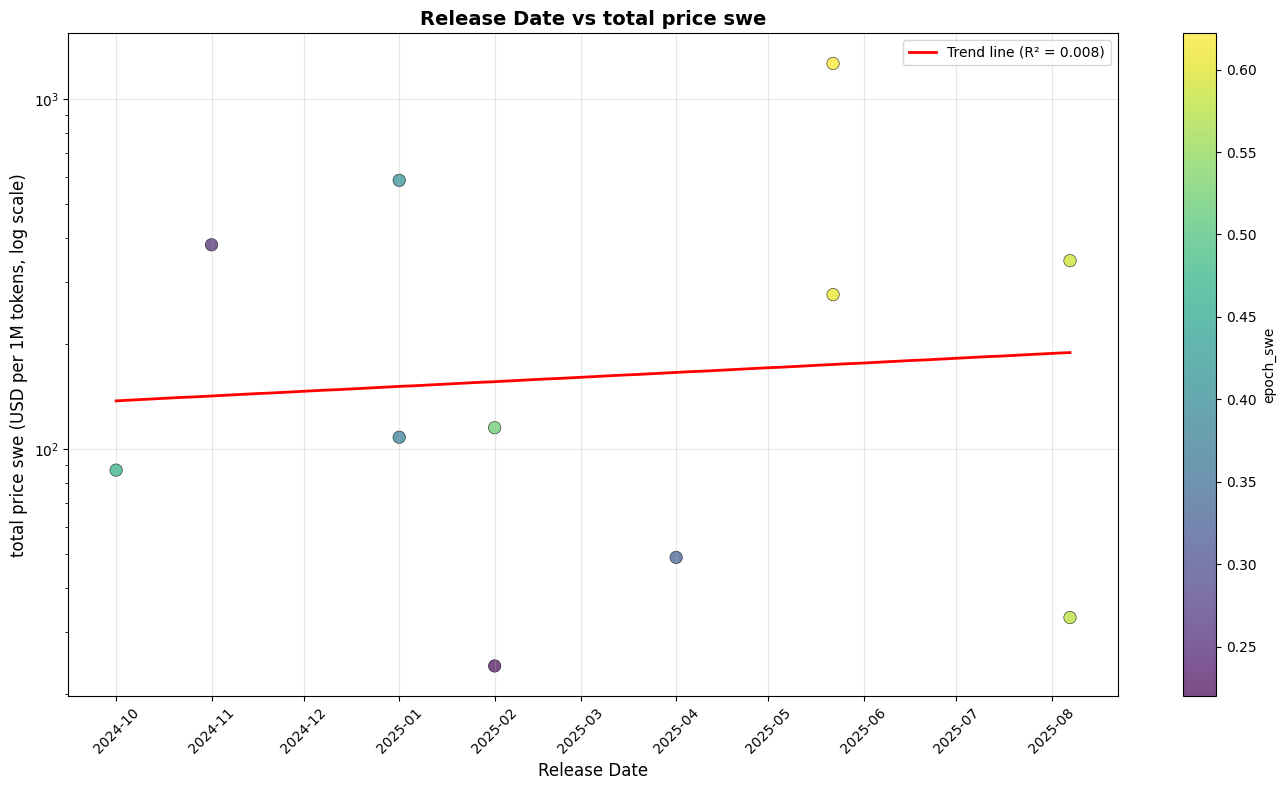


Sample data points:
  Claude 3.5 Sonnet (Oct): $87.00 (2024-10-01)
  Claude 3.7 Sonnet: $115.00 (2025-02-01)
  Gemini 2.0 Flash: $24.00 (2025-02-01)
  GPT-4.1: $585.00 (2025-01-01)
  o3-mini: $108.00 (2025-01-01)
  Claude 4 Opus: $1262.00 (2025-05-22)
  Claude 4 Sonnet: $276.00 (2025-05-22)
  GPT-4.1 mini: $49.00 (2025-04-01)
  GPT-4o (Nov '24): $383.00 (2024-11-01)
  GPT-5 (medium): $345.00 (2025-08-07)


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def load_and_plot_gpqa_price_data(price_col='total price lowest gpqa', benchmark_col='epoch_gpqa'):
    """Load data and create the plot with better error handling
    
    Parameters:
    price_col (str): Column name for price data (default: 'total price lowest gpqa')
    benchmark_col (str): Column name for benchmark scores (default: 'epoch_gpqa')
    """
    
    # Load the data
    df = pd.read_csv('art_analysis_inf_data.csv')
    
    print("Columns in the dataset:")
    for i, col in enumerate(df.columns):
        print(f"{i}: {col}")
    
    # The target columns based on parameters
    date_col = 'Release Date'
    
    # Check if columns exist
    if price_col not in df.columns:
        print(f"Column '{price_col}' not found!")
        # Try to find similar columns
        price_candidates = [col for col in df.columns if 'price' in col.lower()]
        print(f"Possible price columns: {price_candidates}")
        if price_candidates:
            price_col = price_candidates[0]
            print(f"Using '{price_col}' instead")
        else:
            return None
    
    if date_col not in df.columns:
        print(f"Column '{date_col}' not found!")
        return None
    
    if benchmark_col not in df.columns:
        print(f"Column '{benchmark_col}' not found!")
        benchmark_candidates = [col for col in df.columns if benchmark_col.lower() in col.lower()]
        print(f"Possible benchmark columns: {benchmark_candidates}")
        if benchmark_candidates:
            benchmark_col = benchmark_candidates[0]
            print(f"Using '{benchmark_col}' instead")
        else:
            print(f"Will proceed without benchmark scores")
            benchmark_col = None
    
    print(f"\nUsing columns:")
    print(f"Price: {price_col}")
    print(f"Date: {date_col}")
    print(f"Benchmark Score: {benchmark_col}")
    
    # Clean and convert the data
    df_work = df.copy()
    
    # Convert Release Date
    df_work[date_col] = pd.to_datetime(df_work[date_col], errors='coerce')
    
    # Convert price column - handle various formats
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    
    # Convert benchmark score if column exists
    if benchmark_col and benchmark_col in df_work.columns:
        df_work[benchmark_col] = pd.to_numeric(df_work[benchmark_col], errors='coerce')
    
    # Filter to valid data
    valid_data = df_work.dropna(subset=[date_col, price_col])
    valid_data = valid_data[valid_data[price_col] > 0]
    
    print(f"\nData summary:")
    print(f"Total rows: {len(df)}")
    print(f"Rows with valid date and price: {len(valid_data)}")
    
    if len(valid_data) == 0:
        print("No valid data found!")
        print(f"Sample price values: {df[price_col].head(10).tolist()}")
        print(f"Sample date values: {df[date_col].head(10).tolist()}")
        return None
    
    print(f"Date range: {valid_data[date_col].min()} to {valid_data[date_col].max()}")
    print(f"Price range: ${valid_data[price_col].min():.2f} to ${valid_data[price_col].max():.2f}")
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Color by benchmark score if available
    if benchmark_col and benchmark_col in valid_data.columns and valid_data[benchmark_col].notna().sum() > 0:
        # Filter to rows with benchmark scores
        benchmark_data = valid_data.dropna(subset=[benchmark_col])
        if len(benchmark_data) > 0:
            scatter = plt.scatter(
                benchmark_data[date_col], 
                benchmark_data[price_col],
                c=benchmark_data[benchmark_col], 
                cmap='viridis', 
                alpha=0.7,
                s=80,
                edgecolors='black',
                linewidth=0.5
            )
            plt.colorbar(scatter, label=benchmark_col)
            print(f"Plotted {len(benchmark_data)} points with {benchmark_col} scores")
        else:
            plt.scatter(valid_data[date_col], valid_data[price_col], alpha=0.7, s=80)
            print(f"Plotted {len(valid_data)} points (no {benchmark_col} scores available)")
    else:
        plt.scatter(valid_data[date_col], valid_data[price_col], alpha=0.7, s=80)
        print(f"Plotted {len(valid_data)} points (no benchmark score column)")
    
    # Formatting
    plt.yscale('log')
    plt.xlabel('Release Date', fontsize=12)
    plt.ylabel(f'{price_col} (USD per 1M tokens, log scale)', fontsize=12)
    plt.title(f'Release Date vs {price_col}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add trend line if enough data
    if len(valid_data) >= 2:
        from sklearn.linear_model import LinearRegression
        
        # Prepare data for regression
        df_reg = valid_data.sort_values(date_col).copy()
        df_reg['Date_Ordinal'] = df_reg[date_col].map(datetime.toordinal)
        
        X = df_reg['Date_Ordinal'].values.reshape(-1, 1)
        y = np.log(df_reg[price_col].values)
        
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)
        
        # Prediction line
        x_range = np.linspace(X.min(), X.max(), 100)
        y_pred = model.predict(x_range.reshape(-1, 1))
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        
        plt.plot(x_dates, np.exp(y_pred), 'r-', linewidth=2, 
                label=f'Trend line (R² = {r2:.3f})')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show some sample data
    print(f"\nSample data points:")
    sample_data = valid_data[['Model', date_col, price_col]].head(10)
    for idx, row in sample_data.iterrows():
        print(f"  {row['Model']}: ${row[price_col]:.2f} ({row[date_col].strftime('%Y-%m-%d')})")
    
    return valid_data

# Run the analysis with default parameters
result = load_and_plot_gpqa_price_data(price_col='total price swe', benchmark_col='epoch_swe')



# Example usage with different parameters:
# result = load_and_plot_gpqa_price_data(price_col='Lowest Blended Price AA', benchmark_col='HumanEval (Coding)')